In [ ]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client
!pip install google-cloud-bigquery pandas-gbq
!pip install scikit-learn
!pip install plotly
!apt-get install git


In [ ]:
!git config --global user.name "Romina Capurro"
!git config --global user.email "romcapurro@gmail.com"

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
from google.auth import default

# credenciales predeterminadas y el ID del proyecto
credentials, project_id = default()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd


# Configurar el cliente de BigQuery
client = bigquery.Client(project='bummi-ai')

Authenticated


In [ ]:
# Consultas para obtener las tablas desde BigQuery
query_ventas = """
SELECT
    codigo_producto,
    moneda_venta,
    id_cliente,
    fecha_venta,
    monto_ventas_producto,
    cantidad_ventas_producto
FROM
    `bummi-ai.alcechnos.ventas`
"""

query_clientes = """
SELECT
    id,
    razon_soc,
    nombre_fantasia,
    pais,
    departamento,
    ciudad,
    activo,
    tipo_cliente
FROM
    `bummi-ai.alcechnos.clientes`
"""

query_productos = """
SELECT
    codigo_producto,
    descripcion_producto,
    costo_producto,
    precio_producto,
    stock_actual_producto,
    unidad_de_medida_producto,
    proveedor_producto,
    ramo_producto,
    familia_producto,
    grupo_producto,
    marco_producto
FROM
   `bummi-ai.alcechnos.productos`
"""

In [ ]:
# Cargar los datos en DataFrames
productos = client.query(query_productos).to_dataframe()
ventas = client.query(query_ventas).to_dataframe()
clientes = client.query(query_clientes).to_dataframe()


In [ ]:
ventas.head()

,codigo_producto,moneda_venta,id_cliente,fecha_venta,monto_ventas_producto,cantidad_ventas_producto
0,0,$,1241,2022-12-30,0.0,1.0
1,0,$,1258,2022-12-16,0.0,1.0
2,0,$,1201,2024-01-30,0.0,1.0
3,0,$,1260,2023-03-01,0.0,1.0
4,0,$,1403,2023-08-15,0.0,1.0


In [ ]:
# Imprimir categorías únicas en cada columna relevante
print("Categorías únicas en 'ramo_producto':")
print(productos['ramo_producto'].unique())

print("\nCategorías únicas en 'familia_producto':")
print(productos['familia_producto'].unique())

print("\nCategorías únicas en 'grupo_producto':")
print(productos['grupo_producto'].unique())

print("\nCategorías únicas en 'marco_producto':")
print(productos['marco_producto'].unique())


Categorías únicas en 'ramo_producto':
['Sin asignar' 'VACIO2' 'ALIMENTO MASCOTAS' 'HOGAR' 'EMPAQUES'
 'ELABORACION Y PANADERIAS' 'ENVASADOS' 'LIMPIEZA' 'DULCES Y MERMELADAS'
 'CAFE E INFUSIONES' 'BEBIDAS' 'FARMACIA Y TOCADOR' 'ALFAJORES Y GALLETAS'
 'LACTEOS' 'GOLOSINAS' 'ACEITES' 'CONGELADOS' 'FIAMBRES Y QUESOS' 'YERBA'
 'CEREALES, GRANOLAS, SEMILLAS Y FRUTOS SECOS' 'ADEREZOS' 'ENLATADOS'
 'ACEITUNAS' 'GRANEL' 'CONDIMENTOS']

Categorías únicas en 'familia_producto':
['ISSUE' 'DANICA' 'PERROS' 'VARIOS' 'BANDEJA' 'ENVASADOS' 'FLEISCHMANN'
 'Sin asignar' 'MIEL Y JALEAS' 'EDULCORANTE Y AZUCARES' 'JUGOS' 'BALERINA'
 'CAFE' 'COCOA' 'GALLETAS' 'PARMALAT' 'CHOCOLATES' 'DOMESTICOS'
 'CERVEZA ARTESANAL' 'PAPAS' 'CARNES' 'HELADOS' 'VEGETALES' 'GATOS'
 'CHORIZO' 'F SECAS' 'FETEADOS' 'FIAMBRES' 'MERMELADAS' 'DULCES DE CORTES'
 'PASTAS' 'PH' 'ALKLIN' 'GAUCHA' 'ACEITES' 'JABONES' 'PAPEL COCINA'
 'DESINFECTANTES' 'HARINAS' 'LEVADURAS' 'ESENCIA Y COLORES' 'DUKITA'
 'FRUTOS SECOS' 'SAL Y AGREGADOS' 'PV

CALCULO VENTAS TOTALES POR **PRODUCTOS**


In [ ]:
# Calcular las ventas totales por producto
ventas_por_producto = ventas.groupby('codigo_producto')['cantidad_ventas_producto'].sum().reset_index()
ventas_por_producto.columns = ['codigo_producto', 'ventas']

CATEGORIZO LOS **PRODUCTOS**

In [ ]:

# 0Unir ventas con productos para obtener categorías
productos_con_ventas = pd.merge(ventas_por_producto, productos, on='codigo_producto')
print(productos_con_ventas.head())



  codigo_producto  ventas                               descripcion_producto  \
0               0     6.0                      CARTA COLORES TINTA LEAU VIVE   
1              00   164.0            GRATED SARDINA MARINERA 425 GR (24 UNI)   
2             000    91.0  ENDULZANTE SUCRALOSA DOLCELIGTH X 50 SOBRES (1...   
3            0000  1047.0  YERBA BIOMATE CANNABIS 55 GR DISP X 18 UNI (8 ...   
4            0001   839.0         CHOCOLATE GAROTO A LA LECHE 90 GR (16 UNI)   

   costo_producto  precio_producto  stock_actual_producto  \
0           0.000              0.0                   14.0   
1           1.252              1.5                   52.0   
2          83.999            109.0                   17.0   
3          14.796             18.0                   21.0   
4          28.875             36.0                    0.0   

  unidad_de_medida_producto proveedor_producto       ramo_producto  \
0                       Uni     MERCOVENTA SRL  FARMACIA Y TOCADOR   
1           

CALCULO LOS **20 PRODUCTOS**  MÁS VENDIDOS DE CADA **CATEGORÍA**

In [ ]:
# Agrupar por las columnas de categoría y seleccionar los top 20 productos más vendidos en cada grupo
productos_mas_vendidos_por_categoria = productos_con_ventas.groupby(
    ['ramo_producto', 'familia_producto', 'grupo_producto', 'marco_producto']
).apply(lambda x: x.nlargest(20, 'ventas')).reset_index(drop=True)


VISUALIZO LOS **20 PRODUCTOS** MÁS VENDIDOS SEGÚN SUS **CATEGORÍAS**

In [ ]:
import plotly.graph_objs as go

# Crear una lista para almacenar las figuras de los gráficos
figuras = []

# Iterar sobre cada categoría única en el DataFrame de productos_mas_vendidos_por_categoria
for categoria in productos_mas_vendidos_por_categoria['ramo_producto'].unique():
    # Filtrar los productos más vendidos de esta categoría
    productos_categoria = productos_mas_vendidos_por_categoria[productos_mas_vendidos_por_categoria['ramo_producto'] == categoria]

    # Crear una figura de barras para la categoría actual
    figura = go.Figure()
    figura.add_trace(go.Bar(
        x=productos_categoria['descripcion_producto'],
        y=productos_categoria['ventas'],
        name='Ventas',
        marker_color='skyblue'
    ))

    # Actualizar el diseño del gráfico
    figura.update_layout(
        title=f'Top 20 Productos Más Vendidos en la Categoría: {categoria}',
        xaxis_title='Productos',
        yaxis_title='Ventas',
        xaxis_tickangle=-45,  # Rotar las etiquetas del eje x para mejor legibilidad
        showlegend=False  # No mostrar la leyenda
    )

    # Añadir la figura a la lista de figuras
    figuras.append(figura)

# Mostrar las figuras
for figura in figuras:
    figura.show()


CALCULO EL PRODUCTO MENOS VENDIDO PARA CADA **CATEGORÍA**

In [ ]:
# Agrupar por las columnas de categoría y calcular el producto menos vendido en cada grupo
productos_menos_vendidos_por_categoria = productos_con_ventas.groupby(
    ['ramo_producto', 'familia_producto', 'grupo_producto', 'marco_producto']
).apply(lambda x: x.sort_values('ventas', ascending=True).head(1)).reset_index(drop=True)

print(productos_menos_vendidos_por_categoria)


    codigo_producto  ventas  \
0           CG56002     6.0   
1            606813    67.0   
2              1007   199.0   
3              1010   150.0   
4                79   315.0   
..              ...     ...   
277          266007  2326.0   
278            1556   252.0   
279            0000  1047.0   
280         1105103    11.0   
281            1800     7.0   

                                  descripcion_producto  costo_producto  \
0                    ACEITE DORY SUPER FRY 10L (2 UNI)         896.534   
1        ACEITE DE MAIZ SUAVIT S/GLUTEN 900ML (20 UNI)          97.125   
2        ACEITE DE MAIZ RIO DE LA PLATA 900ML (20 UNI)           2.671   
3         ACEITE OLIVA OLIVARES DE ROCHA 500ML (6 UNI)         269.999   
4          ACEITE ALTO OLEICO CAÑUELAS 900 ML (12 UNI)           2.360   
..                                                 ...             ...   
277  TOALLA COCINA SUSSEX CLASICO ROLLO 200 HOJAS D...          48.220   
278               YERBA ARMIÑO CLAS

In [ ]:
# Fusionar los datos de ventas y productos por 'codigo_producto'
ventas_productos = pd.merge(ventas, productos, on='codigo_producto')

# agrupar los datos por la categoría 'ramo_producto' y calcular las ventas
ventas_por_categoria = ventas_productos.groupby('ramo_producto')['monto_ventas_producto'].sum().reset_index()

print(ventas_por_categoria)


                                  ramo_producto  monto_ventas_producto
0                                       ACEITES           2.671087e+06
1                                     ACEITUNAS           6.909762e+05
2                                      ADEREZOS           2.985053e+06
3                          ALFAJORES Y GALLETAS           8.877471e+05
4                             ALIMENTO MASCOTAS           1.294533e+06
5                                       BEBIDAS           1.436963e+06
6                             CAFE E INFUSIONES           4.110540e+05
7   CEREALES, GRANOLAS, SEMILLAS Y FRUTOS SECOS           1.733904e+06
8                                   CONDIMENTOS           1.133409e+06
9                                    CONGELADOS           4.013369e+06
10                          DULCES Y MERMELADAS           7.578537e+06
11                     ELABORACION Y PANADERIAS           2.583731e+07
12                                     EMPAQUES           2.995511e+06
13    

In [ ]:
# Convertir la columna 'fecha_venta' a tipo datetime
ventas['fecha_venta'] = pd.to_datetime(ventas['fecha_venta'])

# Agrupar por trimestre y calcular la suma de las ventas para cada trimestre
ventas_por_trimestre = ventas.groupby(pd.Grouper(key='fecha_venta', freq='Q'))['monto_ventas_producto'].sum().reset_index()

# Mostrar las ventas por trimestre
print(ventas_por_trimestre)

  fecha_venta  monto_ventas_producto
0  2022-06-30           7.126577e+06
1  2022-09-30           1.081235e+07
2  2022-12-31           1.210448e+07
3  2023-03-31           1.195921e+07
4  2023-06-30           1.562700e+07
5  2023-09-30           1.465918e+07
6  2023-12-31           1.406472e+07
7  2024-03-31           1.469726e+07
8  2024-06-30           9.341303e+06


CALCULO LOS **PRODUCTOS MENOS** VENDIDOS EN **TRIMESTRES Y CATEGORIAS**

In [ ]:
# Fusionar los datos de ventas y productos por 'codigo_producto'
ventas_productos = pd.merge(ventas, productos, on='codigo_producto')

# Agrupar las ventas por trimestre y categoría, y calcular la suma de ventas para cada grupo
ventas_por_trimestre_categoria = ventas_productos.groupby([pd.PeriodIndex(ventas_productos['fecha_venta'], freq='Q'), 'ramo_producto', 'descripcion_producto'])['cantidad_ventas_producto'].sum().reset_index()

# Encontrar el producto menos vendido de cada trimestre y categoría
productos_menos_vendidos = ventas_por_trimestre_categoria.groupby([pd.PeriodIndex(ventas_por_trimestre_categoria['fecha_venta'], freq='Q'), 'ramo_producto']).apply(lambda x: x.loc[x['cantidad_ventas_producto'].idxmin()]).reset_index(drop=True)

# Mostrar los productos menos vendidos de cada trimestre y categoría
print(productos_menos_vendidos)



    fecha_venta         ramo_producto  \
0        2022Q2               ACEITES   
1        2022Q2             ACEITUNAS   
2        2022Q2              ADEREZOS   
3        2022Q2  ALFAJORES Y GALLETAS   
4        2022Q2     ALIMENTO MASCOTAS   
..          ...                   ...   
214      2024Q2                 HOGAR   
215      2024Q2               LACTEOS   
216      2024Q2              LIMPIEZA   
217      2024Q2           Sin asignar   
218      2024Q2                 YERBA   

                                  descripcion_producto  \
0         ACEITE ARROZ Y ALGODON FIORELLA 5 LT (4 UNI)   
1       ACEITUNAS CON CAROZO REVELACION 1.5 KG (8 UNI)   
2                             KETCHUP NATURA 8 CC X192   
3     GALLETAS ANILLITOS 9 DE ORO COCO 120 GR (16 UNI)   
4               ALIMENTO SPECIAL DOG CARNE ADULTO 20KG   
..                                                 ...   
214                              ESPATULA CALADA RECTA   
215                   LECHE DESLACTOSADA PA

VISUALIZO LOS **PRODCTOS MENOS** VENDIDOS POR **TRIMESTRE Y CATEGORIAS**

In [ ]:
import plotly.express as px

# Crear el gráfico interactivo
fig = px.bar(productos_menos_vendidos,
             x='ramo_producto',
             y='cantidad_ventas_producto',
             color='fecha_venta',
             barmode='group',
             title='Productos Menos Vendidos por Categoría y Trimestre',
             labels={'ramo_producto': 'Categoría', 'cantidad_ventas_producto': 'Cantidad de Ventas'},
             )

# Ajustar el diseño
fig.update_layout(xaxis={'categoryorder':'total descending'}, xaxis_title='Categoría')

# Añadir etiquetas emergentes (hover labels)
fig.update_traces(hovertemplate='Producto: %{text}',
                  text=productos_menos_vendidos['descripcion_producto'])

# Mostrar el gráfico
fig.show()


CALCULO LAS **VENTAS DE TOTALES POR MES** Y **EL MEJOR MES DE VENTAS**

In [ ]:

# Agrupar las ventas por mes y sumar las ventas de cada mes
ventas_por_mes = ventas.groupby(ventas['fecha_venta'].dt.to_period('M'))['monto_ventas_producto'].sum().reset_index()

# Convertir los periodos a cadenas
ventas_por_mes['fecha_venta'] = ventas_por_mes['fecha_venta'].astype(str)

# Encontrar el mes con las ventas más altas
mejor_mes_ventas = ventas_por_mes.loc[ventas_por_mes['monto_ventas_producto'].idxmax()]

VISUALIZO LAS **VENTAS POR MES**

In [ ]:
# Crear una figura de barras para visualizar las ventas por mes
figura_ventas_mes = go.Figure()
figura_ventas_mes.add_trace(go.Bar(
    x=ventas_por_mes['fecha_venta'],
    y=ventas_por_mes['monto_ventas_producto'],
    marker_color='skyblue'
))

# Actualizar el diseño del gráfico
figura_ventas_mes.update_layout(
    title='Ventas por Mes',
    xaxis_title='Mes',
    yaxis_title='Ventas',
    xaxis_tickangle=-45,  # Rotar las etiquetas del eje x para mejor legibilidad
)

# Mostrar el gráfico
figura_ventas_mes.show()

# Imprimir el mes con las ventas más altas
print(f"El mejor mes en términos de ventas fue {mejor_mes_ventas['fecha_venta']} con un total de ventas de ${mejor_mes_ventas['monto_ventas_producto']:.2f}")

El mejor mes en términos de ventas fue 2023-05 con un total de ventas de $5345786.28


INICIO MIS **CANASTAS**



*Agrupo productos por categorías*

In [ ]:
# Verificar las categorías disponibles
print(productos['ramo_producto'].unique())

# Agrupar productos por categorías y calcular algunas estadísticas básicas
productos_por_categoria = productos.groupby('ramo_producto').agg({
    'codigo_producto': 'count',
    'costo_producto': 'mean',
    'precio_producto': 'mean',
    'stock_actual_producto': 'sum'
}).reset_index()

# Renombrar las columnas para mayor claridad
productos_por_categoria.columns = ['Categoría', 'Número de Productos', 'Costo Promedio', 'Precio Promedio', 'Stock Total']

# Mostrar el resultado
print(productos_por_categoria)


['Sin asignar' 'VACIO2' 'ALIMENTO MASCOTAS' 'HOGAR' 'EMPAQUES'
 'ELABORACION Y PANADERIAS' 'ENVASADOS' 'LIMPIEZA' 'DULCES Y MERMELADAS'
 'CAFE E INFUSIONES' 'BEBIDAS' 'FARMACIA Y TOCADOR' 'ALFAJORES Y GALLETAS'
 'LACTEOS' 'GOLOSINAS' 'ACEITES' 'CONGELADOS' 'FIAMBRES Y QUESOS' 'YERBA'
 'CEREALES, GRANOLAS, SEMILLAS Y FRUTOS SECOS' 'ADEREZOS' 'ENLATADOS'
 'ACEITUNAS' 'GRANEL' 'CONDIMENTOS']
                                      Categoría  Número de Productos  \
0                                       ACEITES                   22   
1                                     ACEITUNAS                    9   
2                                      ADEREZOS                   47   
3                          ALFAJORES Y GALLETAS                   30   
4                             ALIMENTO MASCOTAS                    7   
5                                       BEBIDAS                   76   
6                             CAFE E INFUSIONES                   31   
7   CEREALES, GRANOLAS, SEMILLAS

*Segmentación de clientes*

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preparar los datos de clientes para clustering
clientes_data = ventas.groupby('id_cliente').agg({
    'codigo_producto': 'nunique' # Cantidad de productos diferentes comprados
}).reset_index()

# Estandarizar los datos
scaler = StandardScaler()
clientes_scaled = scaler.fit_transform(clientes_data[['codigo_producto']])

# Aplicar K-means clustering
kmeans = KMeans(n_clusters=25, n_init='auto', random_state=42) # Establecer n_init explícitamente
clientes_data['Segmento'] = kmeans.fit_predict(clientes_scaled)

# Mostrar los segmentos de clientes
print(clientes_data.head())


   id_cliente  codigo_producto  Segmento
0           1               26        18
1           2               56        14
2           7               16        15
3           8               19         1
4          12                2         9


*Recomendación basada en categorías de productos y segmentos de clientes*

In [ ]:
# Calcular los productos más comprados por cada segmento
segmento_producto = ventas.merge(clientes_data[['id_cliente', 'Segmento']], on='id_cliente')

# Agrupar por segmento y producto, luego sumar la cantidad de ventas
segmento_producto_agg = segmento_producto.groupby(['Segmento', 'codigo_producto']).agg({
    'cantidad_ventas_producto': 'sum'
}).reset_index()

# Obtener los productos más comprados por cada segmento, ordenando por la cantidad de ventas
productos_recomendados = segmento_producto_agg.sort_values(['Segmento', 'cantidad_ventas_producto'], ascending=[True, False]).groupby('Segmento').head(5)

# Añadir la descripción del producto
productos_recomendados = productos_recomendados.merge(productos[['codigo_producto', 'descripcion_producto']], on='codigo_producto')

# Mostrar los productos recomendados por segmento
print(productos_recomendados)


     Segmento codigo_producto  cantidad_ventas_producto  \
0           0            1238                  8725.000   
1           1            1238                  2215.000   
2           3            1238                   322.000   
3           4            1238                  6935.000   
4           5            1238                  1863.000   
..        ...             ...                       ...   
120        23            5888                  1505.000   
121        24         BIZ0269                   140.000   
122        24            109A                   134.000   
123        24            1249                   127.248   
124        24            7914                   124.000   

                                  descripcion_producto  
0                     MAYONESA URUGUAY 125 GR (20 UNI)  
1                     MAYONESA URUGUAY 125 GR (20 UNI)  
2                     MAYONESA URUGUAY 125 GR (20 UNI)  
3                     MAYONESA URUGUAY 125 GR (20 UNI)  
4     

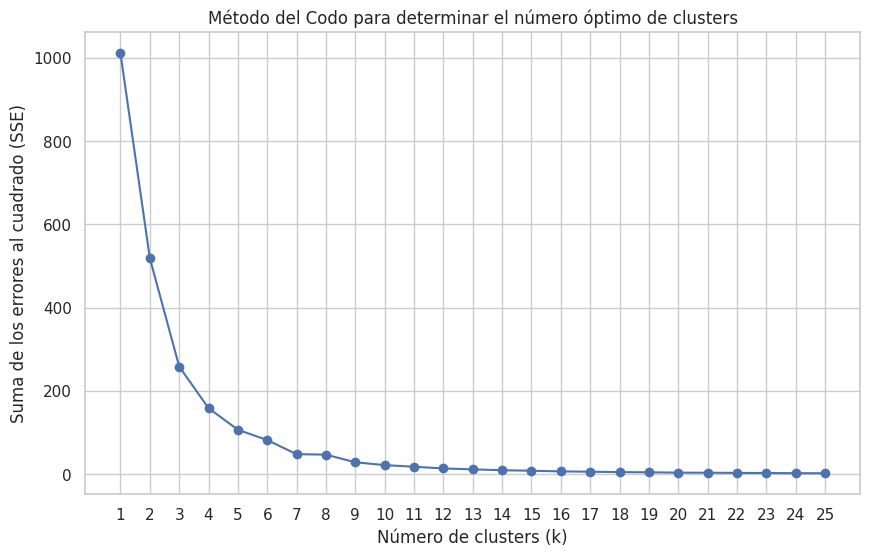

In [ ]:
# Calcular la suma de los errores al cuadrado (SSE) para diferentes valores de k
sse = []
k_range = range(1, 26)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(clientes_scaled)
    sse.append(kmeans.inertia_)

# Visualizar el gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de los errores al cuadrado (SSE)')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

*VISUALIZACIÓN DE LAS RECOMENDACIONES POR SEGMENTO*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar los datos de compra de productos por cliente
ventas_productos_cliente = ventas.groupby(['id_cliente', 'codigo_producto']).size().reset_index(name='compras')
ventas_productos_cliente['compras'] = ventas_productos_cliente['compras'].apply(lambda x: 1 if x > 0 else 0)

# Pivotar los datos para crear la matriz de compra
matriz_compras = ventas_productos_cliente.pivot(index='id_cliente', columns='codigo_producto', values='compras').fillna(0)

# Obtener la descripción del producto
codigo_to_descripcion = productos.set_index('codigo_producto')['descripcion_producto'].to_dict()
matriz_compras.columns = [codigo_to_descripcion.get(col, col) for col in matriz_compras.columns]

# Crear una figura más grande
plt.figure(figsize=(16, 12))

# Crear el gráfico de barras apiladas
matriz_compras.T.plot(kind='bar', stacked=True, figsize=(16, 12), legend=False)

# Añadir título y etiquetas
plt.title('Comportamiento de Compra de Clientes por Producto')
plt.xlabel('Producto')
plt.ylabel('Clientes')
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


### **MODELO DE RECOMENDACIÓN**